In [3]:
import os
### QAOA_realestate가 있는 폴더로 지정
dir_path = "/Users/minhyeong-gyu/Documents/GitHub/QuantumVariableSelection"
os.chdir(dir_path)
import sys
module_path = dir_path + "/Module"
if module_path not in sys.path:
    sys.path.append(module_path)

from optimizer import optimizer as opt
from optimizer import basefunctions as bf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import font_manager, rc
# 윈도우 한글 폰트
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

# Mac 한글 폰트
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
from dwave.system import LeapHybridCQMSampler
%matplotlib inline

In [5]:
import json
from os import listdir
from os.path import isfile, join
filepath = "result/simulation_measure_logistics/"
onlyfiles = [f for f in listdir(filepath) if isfile(join(filepath, f))]
test_index = [True if onlyfiles[i][:4]=="test" else False for i in range(len(onlyfiles))]
dict_list = np.array(onlyfiles)[test_index]

arg_list = []
for dict_name in dict_list:
    with open("result/simulation_measure_logistics/"+dict_name,"r") as f:
        dict_temp = json.loads(f.read())
        dict_temp["index"] = dict_name[13:18]
        arg_list +=[dict_temp]
arg_df = []
for i in range(len(arg_list)):
    arg_df += [list(arg_list[i].values())]
arg_df = pd.DataFrame(arg_df)
key_names = arg_list[0].keys()
arg_df.columns = key_names
arg_df = arg_df[[arg_df.columns[-1]] + list(arg_df.columns[:-1])]
arg_df.to_csv("result/simulation_measure_logistics/experient_list.csv")

In [2]:
number_influentials =5
number_features = 50
number_samples = 1000
covariance_parameter = 10
epsilon = None
lmbd = 0.05
beta_coef = np.concatenate([np.random.normal(5,2,number_influentials),np.zeros(number_features-number_influentials)])
if epsilon == None :
    epsilon = number_influentials*5/3
else :
    epsilon = epsilon
X,y = bf.generate_dependent_sample(number_samples,number_features,beta_coef,covariance_parameter=covariance_parameter,epsilon=epsilon)
lmbd = lmbd
Q,beta = bf.get_selecting_qubo(X,y)

In [83]:
ga_qubo = opt.GeneticAlgorithm("QUBO",
                n_gen=100, 
                n_sol=40, 
                n_par=20 )
ga_qubo_result = ga_qubo.optimize(X,y,lmbd)
sa_qubo = opt.SimulatedAnnealing("QUBO")
sa_qubo_result = sa_qubo.optimize(X,y,lmbd,reps=10)

/Users/minhyeong-gyu/Documents/GitHub/QuantumVariableSelection/Module/optimizer/optimizer.py:92: RuntimeWarning: overflow encountered in exp
  Q,beta = bf.get_selecting_qubo(X,y)
/Users/minhyeong-gyu/Documents/GitHub/QuantumVariableSelection/Module/optimizer/basefunctions.py:90: RuntimeWarning: invalid value encountered in reciprocal
  SSRF = y.T@(np.identity(n) - projection(X_pre))@y/np.cov(y)


In [13]:
ga_aic = opt.GeneticAlgorithm(mode = "AIC",
                n_gen=100, 
                n_sol=40, 
                n_par=20)
ga_aic_result = ga_qubo.optimize(X,y,lmbd)
sa_aic = opt.SimulatedAnnealing("AIC")
sa_aic_result = sa_qubo.optimize(X,y,lmbd,reps=10)

/Users/minhyeong-gyu/Documents/GitHub/QuantumVariableSelection/Module/optimizer/basefunctions.py:88: RuntimeWarning: invalid value encountered in reciprocal
  result = np.array(SSRP)**(-1)*SSRF
/Users/minhyeong-gyu/Documents/GitHub/QuantumVariableSelection/Module/optimizer/optimizer.py:91: RuntimeWarning: overflow encountered in exp
  if np.random.rand(1) <= min(1, np.exp((bf.get_QB(theta_temp,Q,-1*beta,lamda)-bf.get_QB(theta_star,Q,-1*beta,lamda))/tau)):


In [14]:
X_sa_qubo = X[:,sa_qubo_result.astype(bool)]
X_ga_qubo = X[:,ga_qubo_result.astype(bool)]
X_sa_aic = X[:,sa_aic_result.astype(bool)]
X_ga_aic = X[:,ga_aic_result.astype(bool)]

In [18]:
AIC_list = [
    bf.get_aic(X,y),
    bf.get_aic(X_sa_aic,y),
    bf.get_aic(X_ga_aic,y),
    bf.get_aic(X_sa_qubo,y),
    bf.get_aic(X_ga_qubo,y)]

QUBO_list = [
    bf.get_QUBO(X,y,lmbd),
    bf.get_QUBO(X_sa_aic,y,lmbd),
    bf.get_QUBO(X_ga_aic,y,lmbd),
    bf.get_QUBO(X_sa_qubo,y,lmbd),
    bf.get_QUBO(X_ga_qubo,y,lmbd)]

MSPE_list = [
    bf.get_MSPE(X,y,0.8),
    bf.get_MSPE(X_sa_aic,y,0.8),
    bf.get_MSPE(X_ga_aic,y,0.8),
    bf.get_MSPE(X_sa_qubo,y,0.8),
    bf.get_MSPE(X_ga_qubo,y,0.8)]

R2_list = [
    bf.get_prediction_R2(X,y,0.8),
    bf.get_prediction_R2(X_sa_aic,y,0.8),
    bf.get_prediction_R2(X_ga_aic,y,0.8),    
    bf.get_prediction_R2(X_sa_qubo,y,0.8),
    bf.get_prediction_R2(X_ga_qubo,y,0.8)]

CN_list = [
    bf.get_CN(X),
    bf.get_CN(X_sa_aic),
    bf.get_CN(X_ga_aic),
    bf.get_CN(X_sa_qubo),
    bf.get_CN(X_ga_qubo)]


result_table = pd.DataFrame([AIC_list,QUBO_list,MSPE_list,R2_list,CN_list])
result_table.columns = ["Original","SA_AIC","GA_AIC","SA_QUBO","GA_QUBO"]
result_table.index = ["AIC_list","QUBO_list","MSPE","R2","CN"]

/Users/minhyeong-gyu/Documents/GitHub/QuantumVariableSelection/Module/optimizer/basefunctions.py:88: RuntimeWarning: invalid value encountered in reciprocal
  result = np.array(SSRP)**(-1)*SSRF


In [19]:
result_table

,Original,SA_AIC,GA_AIC,SA_QUBO,GA_QUBO
AIC_list,6895.977379,8162.261767,8372.115699,8172.906549,8297.854468
QUBO_list,5.715941,1.914223,2.370875,1.741336,2.387763
MSPE,2.388663,4.651134,4.770355,4.289099,4.331387
R2,0.627703,0.406248,0.261583,0.394170,0.268922
CN,25.695256,3.561128,4.062565,2.556361,4.318683


In [44]:
AIC_list_total =[]
QUBO_list_total = []
MSPE_list_total = []
R2_list_total = []
CN_list_total = []

for ite in range(2):
    beta_coef = np.concatenate([np.random.normal(5,2,20),np.zeros(80)])
    X,y = bf.generate_dependent_sample(1000,100,beta_coef,epsilon=30)
    lmbd = 0.05

    ga_qubo = opt.GeneticAlgorithm("QUBO")
    ga_qubo_result = ga_qubo.optimize(X,y,lmbd)
    sa_qubo = opt.SimulatedAnnealing("QUBO")
    sa_qubo_result = sa_qubo.optimize(X,y,lmbd,reps=10)
    ga_aic = opt.GeneticAlgorithm(mode = "AIC")
    ga_aic_result = ga_qubo.optimize(X,y,lmbd)
    sa_aic = opt.SimulatedAnnealing("AIC")
    sa_aic_result = sa_qubo.optimize(X,y,lmbd,reps=10)

    X_sa_qubo = X[:,sa_qubo_result.astype(bool)]
    X_ga_qubo = X[:,ga_qubo_result.astype(bool)]
    X_sa_aic = X[:,sa_aic_result.astype(bool)]
    X_ga_aic = X[:,ga_aic_result.astype(bool)]

    AIC_list = [
        bf.get_aic(X,y),
        bf.get_aic(X_sa_aic,y),
        bf.get_aic(X_ga_aic,y),
        bf.get_aic(X_sa_qubo,y),
        bf.get_aic(X_ga_qubo,y)]

    QUBO_list = [
        bf.get_QUBO(X,y,lmbd),
        bf.get_QUBO(X_sa_aic,y,lmbd),
        bf.get_QUBO(X_ga_aic,y,lmbd),
        bf.get_QUBO(X_sa_qubo,y,lmbd),
        bf.get_QUBO(X_ga_qubo,y,lmbd)]

    MSPE_list = [
        bf.get_MSPE(X,y,0.8),
        bf.get_MSPE(X_sa_aic,y,0.8),
        bf.get_MSPE(X_ga_aic,y,0.8),
        bf.get_MSPE(X_sa_qubo,y,0.8),
        bf.get_MSPE(X_ga_qubo,y,0.8)]

    R2_list = [
        bf.get_prediction_R2(X,y,0.8),
        bf.get_prediction_R2(X_sa_aic,y,0.8),
        bf.get_prediction_R2(X_ga_aic,y,0.8),    
        bf.get_prediction_R2(X_sa_qubo,y,0.8),
        bf.get_prediction_R2(X_ga_qubo,y,0.8)]

    CN_list = [
        bf.get_CN(X),
        bf.get_CN(X_sa_aic),
        bf.get_CN(X_ga_aic),
        bf.get_CN(X_sa_qubo),
        bf.get_CN(X_ga_qubo)]

    AIC_list_total += [AIC_list]
    QUBO_list_total += [QUBO_list]
    MSPE_list_total += [MSPE_list]
    R2_list_total += [R2_list]
    CN_list_total += [CN_list]

target = AIC_list_total
AIC_result = pd.DataFrame(target).apply(lambda x: str(round(np.mean(x),2)))+"("+pd.DataFrame(target).apply(lambda x: str(round(np.std(x),2)))+")"
target = QUBO_list_total
QUBO_result = pd.DataFrame(target).apply(lambda x: str(round(np.mean(x),2)))+"("+pd.DataFrame(target).apply(lambda x: str(round(np.std(x),2)))+")"
target = MSPE_list_total
MSPE_result = pd.DataFrame(target).apply(lambda x: str(round(np.mean(x),2)))+"("+pd.DataFrame(target).apply(lambda x: str(round(np.std(x),2)))+")"
target = R2_list_total
R2_result = pd.DataFrame(target).apply(lambda x: str(round(np.mean(x),2)))+"("+pd.DataFrame(target).apply(lambda x: str(round(np.std(x),2)))+")"
target = CN_list_total
CN_result = pd.DataFrame(target).apply(lambda x: str(round(np.mean(x),2)))+"("+pd.DataFrame(target).apply(lambda x: str(round(np.std(x),2)))+")"


result_table = pd.DataFrame([AIC_result,QUBO_result,MSPE_result,R2_result,CN_result])
result_table.columns = ["Original","SA_AIC","GA_AIC","SA_QUBO","GA_QUBO"]
result_table.index = ["AIC_list","QUBO_list","MSPE","R2","CN"]



/Users/minhyeong-gyu/Documents/GitHub/QuantumVariableSelection/Module/optimizer/basefunctions.py:88: RuntimeWarning: invalid value encountered in reciprocal
  result = np.array(SSRP)**(-1)*SSRF
/Users/minhyeong-gyu/Documents/GitHub/QuantumVariableSelection/Module/optimizer/optimizer.py:91: RuntimeWarning: overflow encountered in exp
  if np.random.rand(1) <= min(1, np.exp((bf.get_QB(theta_temp,Q,-1*beta,lamda)-bf.get_QB(theta_star,Q,-1*beta,lamda))/tau)):
/Users/minhyeong-gyu/Documents/GitHub/QuantumVariableSelection/Module/optimizer/optimizer.py:91: RuntimeWarning: overflow encountered in exp
  if np.random.rand(1) <= min(1, np.exp((bf.get_QB(theta_temp,Q,-1*beta,lamda)-bf.get_QB(theta_star,Q,-1*beta,lamda))/tau)):
/Users/minhyeong-gyu/Documents/GitHub/QuantumVariableSelection/Module/optimizer/basefunctions.py:88: RuntimeWarning: invalid value encountered in reciprocal
  result = np.array(SSRP)**(-1)*SSRF
/Users/minhyeong-gyu/Documents/GitHub/QuantumVariableSelection/Module/optimizer/

In [53]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")

In [68]:
import random

In [80]:
random_index = str(random.randrange(0,99999)).zfill(5)

'22351'

In [45]:
result_table.to_csv("result/simulation/linear_samples"+current_time+".csv")

,Original,SA_AIC,GA_AIC,SA_QUBO,GA_QUBO
AIC_list,6872.08(14.77),7784.07(595.19),7894.9(38.8),7823.93(627.73),7846.85(30.43)
QUBO_list,5.92(0.74),3.1(1.13),3.8(0.45),3.12(1.22),3.79(0.37)
MSPE,2.24(0.07),3.68(1.01),3.74(0.09),3.68(1.24),3.75(0.17)
R2,0.71(0.03),0.56(0.1),0.5(0.03),0.52(0.11),0.52(0.02)
CN,27.29(0.97),2.66(0.59),5.41(0.28),2.74(0.19),5.26(0.13)


In [7]:
from os import listdir
from os.path import isfile, join
filepath = "result/simulation/"
onlyfiles = [f for f in listdir(filepath) if isfile(join(filepath, f))]
test_index = [True if onlyfiles[i][:4]=="test" else False for i in range(len(onlyfiles))]
dict_list = np.array(onlyfiles)[test_index]

In [57]:
import json
  
arg_list = []
for dict_name in dict_list:
    with open("result/simulation/"+dict_name,"r") as f:
        dict_temp = json.loads(f.read())
        dict_temp["index"] = dict_name[13:18]
        arg_list +=[dict_temp]

In [200]:
arg_df = []
for i in range(len(arg_list)):
    arg_df += [list(arg_list[i].values())]
arg_df = pd.DataFrame(arg_df)
key_names = arg_list[0].keys()
arg_df.columns = key_names
arg_df = arg_df[[arg_df.columns[-1]] + list(arg_df.columns[:-1])]
arg_df.to_csv("result/simulation/experient_list.csv")

IndexError: list index out of range

In [216]:
def mutual_information(x1,x2,bins=10):
    n = len(x1)
    pr1 = np.histogram(x1,bins=bins)[0]/n+10**(-8)
    pr2 = np.histogram(x2,bins=bins)[0]/n+10**(-8)
    joint = np.histogram2d(x1,x2,bins=bins)[0]/n+10**(-8)
    joint_indep = np.outer(pr1,pr2)
    mi = 0
    for i in range(bins) :
        for j in range(bins) :
            mi += joint[i,j]*np.log(joint[i,j]/joint_indep[i,j])
    return mi
    
def mutual_information_matrix(X,y=None,bins=10):
    if  type(y) != np.ndarray :
        X = np.asarray(X)
        p = X.shape[1]
        mi_matrix = np.ones((p,p))
        for i in range(p):
            for j in range(p):
                mi_matrix[i,j] = mutual_information(X[:,i],X[:,j],bins) 
        return mi_matrix
    else :
        X = np.asarray(X); y = np.asarray(y)
        p = X.shape[1]
        mi_vector = np.ones((p))        
        for i in range(p):
            mi_vector[i] = mutual_information(X[:,i],y,bins)
        return mi_vector 


In [12]:
number_samples = 500
number_features = 20
number_influentials = 8
epsilon = 0
covariance_parameter = 40
beta_coef = np.concatenate([np.random.normal(5,2,number_influentials),np.zeros(number_features-number_influentials)])
X,y = bf.generate_dependent_sample_logistic(number_samples,number_features,beta_coef,covariance_parameter=30,epsilon=0)
y_type = "binary"
lmbd = 0.01

In [3]:
number_influentials =5
number_features = 20
number_samples = 1000
covariance_parameter = 10
epsilon = None
lmbd = 0.05
beta_coef = np.concatenate([np.random.normal(5,2,number_influentials),np.zeros(number_features-number_influentials)])
if epsilon == None :
    epsilon = number_influentials*5/3
else :
    epsilon = epsilon
X,y = bf.generate_dependent_sample(number_samples,number_features,beta_coef,covariance_parameter=covariance_parameter,epsilon=epsilon)
lmbd = lmbd

In [16]:
Q,beta = bf.get_selecting_qubo(X,y,y_type="binary",measure="partial")
print(Q.shape,beta.shape)

(20, 20) (20,)


/Users/minhyeong-gyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
beta

array([ 3.46228158e-02,  1.62858706e-02,  5.66928221e-03,  9.78511079e-04,
        3.18782339e-03,  2.36382211e-02,  3.49947924e-03,  2.42094935e-03,
        6.10041627e-04,  3.25699054e-05,  2.46796320e-02,  1.83650146e-02,
       -2.49382496e-05,  8.20385398e-03, -4.44511949e-05,  1.94510728e-03,
       -7.40629122e-05,  2.80712867e-03,  4.06847515e-03,  3.32154758e-03])

In [18]:
Q

array([[ 1.00000000e+00, -1.96423100e-01, -8.08755149e-02,
        -2.20202726e-01,  3.81816441e-01,  7.64660406e-02,
         2.04022272e-01,  4.12147661e-01, -4.51696984e-02,
        -3.03924543e-01,  1.84367962e-01, -7.24376691e-02,
         3.18171250e-01, -4.59632993e-01,  2.99211353e-01,
         5.24940676e-01,  7.47083594e-02,  8.72805144e-02,
         2.75805099e-01,  6.66071347e-02],
       [-1.96423100e-01,  1.00000000e+00,  7.27737356e-02,
         1.68871846e-01,  6.21360639e-02, -3.05401939e-01,
        -7.70264257e-02,  3.19387495e-02, -9.05013448e-02,
        -3.45549298e-01, -8.50504544e-02,  9.74741027e-02,
         5.34707933e-02,  3.22351334e-01,  3.04867623e-02,
        -4.22831747e-01, -1.02619505e-02, -1.17600616e-01,
        -2.73834213e-01, -5.12904318e-02],
       [-8.08755149e-02,  7.27737356e-02,  1.00000000e+00,
         2.80637963e-01,  1.09011155e-01, -3.24802825e-01,
        -2.33682371e-01,  3.50787165e-01,  2.16797929e-01,
        -2.60280528e-01,  5.9

In [118]:
number_influentials =4
number_features = 10
number_samples = 1000
covariance_parameter = 10
epsilon = None
lmbd = 0.05

In [119]:
beta_coef = np.concatenate([np.random.normal(5,2,number_influentials),np.zeros(number_features-number_influentials)])
if epsilon == None :
    epsilon = number_influentials*5/3
else :
    epsilon = epsilon
X,y = bf.generate_dependent_sample(number_samples,number_features,beta_coef,covariance_parameter=covariance_parameter,epsilon=epsilon)

In [193]:
beta_coef = np.concatenate([np.array([4,3,2,2]),np.zeros(number_features-number_influentials)])
epsilon = 1
X,y = bf.generate_dependent_sample(number_samples,number_features,beta_coef,covariance_parameter=covariance_parameter,epsilon=epsilon)

In [194]:
p = X.shape[1]
mi_score = bf.mutual_information_matrix(X,y)
corr_score = bf.get_full_r2(X,y)
partial_cor_score = bf.get_partial_r2(X,y)

<AxesSubplot:xlabel='Variable', ylabel='Score'>

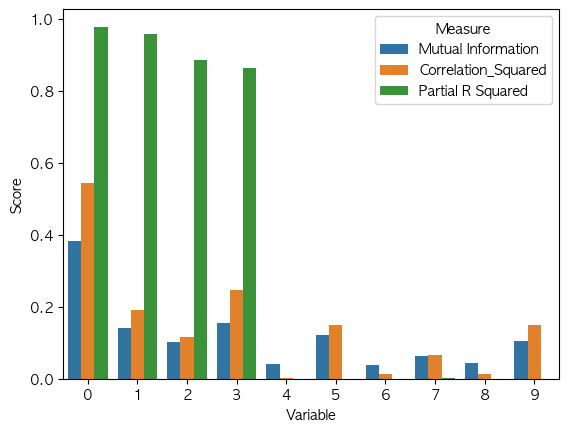

In [198]:
p = X.shape[1]
plot_df_val = mi_score.T.tolist()+corr_score.tolist()+partial_cor_score.tolist()
plot_df_var = [i for i in range(p)]+[i for i in range(p)]+[i for i in range(p)]
plot_df_hue = ["Mutual Information" for i in range(p)] + ["Correlation_Squared" for i in range(p)] +["Partial R Squared" for i in range(p)]
plot_df = pd.DataFrame()
plot_df["Measure"] = plot_df_hue
plot_df["Variable"] = plot_df_var
plot_df["Score"] = plot_df_val
sns.barplot(x= "Variable",y="Score",hue = "Measure",data = plot_df)